# When is a PPR More Attractive Than Investing Directly in its Underlying Assets?

We can see PPRs as wrappers for financial assets. Investors could buy those assets directly, or decide to buy a PPR that holds them. In both cases, investors are putting their money in the assets themselves, but in ways that differ in tax treatment and costs.

PPR costs can be broken down into two categories:
- Explicit costs, being the most significant one in this category the annual commission charged by PPR fund managers.
- Hidden costs, reflected in deviations between the PPR's returns and its underlying assets' returns not explained by the explicit costs.

Going for a PPR, instead of investing directly in its underlying assets, is only worth it when the beneficial tax treatment more than offsets these costs. In other words, for the following equation to be true,

$$
PPR \; Tax \text{-} Net \; Value > Underlying \; Assets \; Tax \text{-} Net \; Value
$$

which can be decomposed into

$$
Gross \; Underlying \; Assets \; Value - Taxes \; on \; PPRs + PPR \; Tax \; Benefits - PPR \; Costs > Gross \; Underlying \; Assets \; Value - Taxes \; on \; Underlying \; Assets
$$

the following needs to be true

$$
PPR \; Tax \; Benefits - PPR \; Costs - ( Taxes \; on \; PPRs - Taxes \; on \; Underlying \; Assets ) > 0
$$

$Taxes$ and $Tax \; Benefits$ are determined by the government and specific to each individual. Fund managers can only control the $PPR \; Costs$. Our goal in this study is to understand when a PPR is more attractive than investing directly in its underlying assets, considering both $PPR \; Costs$ and investors' tax situations.

## Bird's-eye view of cost rates

The first figure presented below shows an overview of the annual cost PPRs can charge,
- to generate significantly higher tax-net values than an equivalent investment in the underlying assets (in y-axis),
- calculated for different performances of the underlying assets, consistent with returns typically generated by a all-stocks portfolio (in x-axis),
- but also considering the tax rate the investor would pay on capital gains generated by direct investment in the underlying assets (in figures),
- the tax credit the investor gets when investing in a PPR (in columns),
- and the number of years the investor will hold the investment (in rows).

To build the figure, we used the [`matching_ppr_cost_rate()`](https://goncalovf.github.io/pyppr/generated/pyppr.matching_ppr_cost_rate.html#pyppr.matching_ppr_cost_rate) function, which was created as part of this study and made available through a Python library called [PyPPR](https://goncalovf.github.io/pyppr/). `matching_ppr_cost_rate()` takes the equation above and solves it to $PPR \; Costs$. Note that `matching_ppr_cost_rate()` considers that the tax credit generated by the PPR is also reinvested in the PPR.

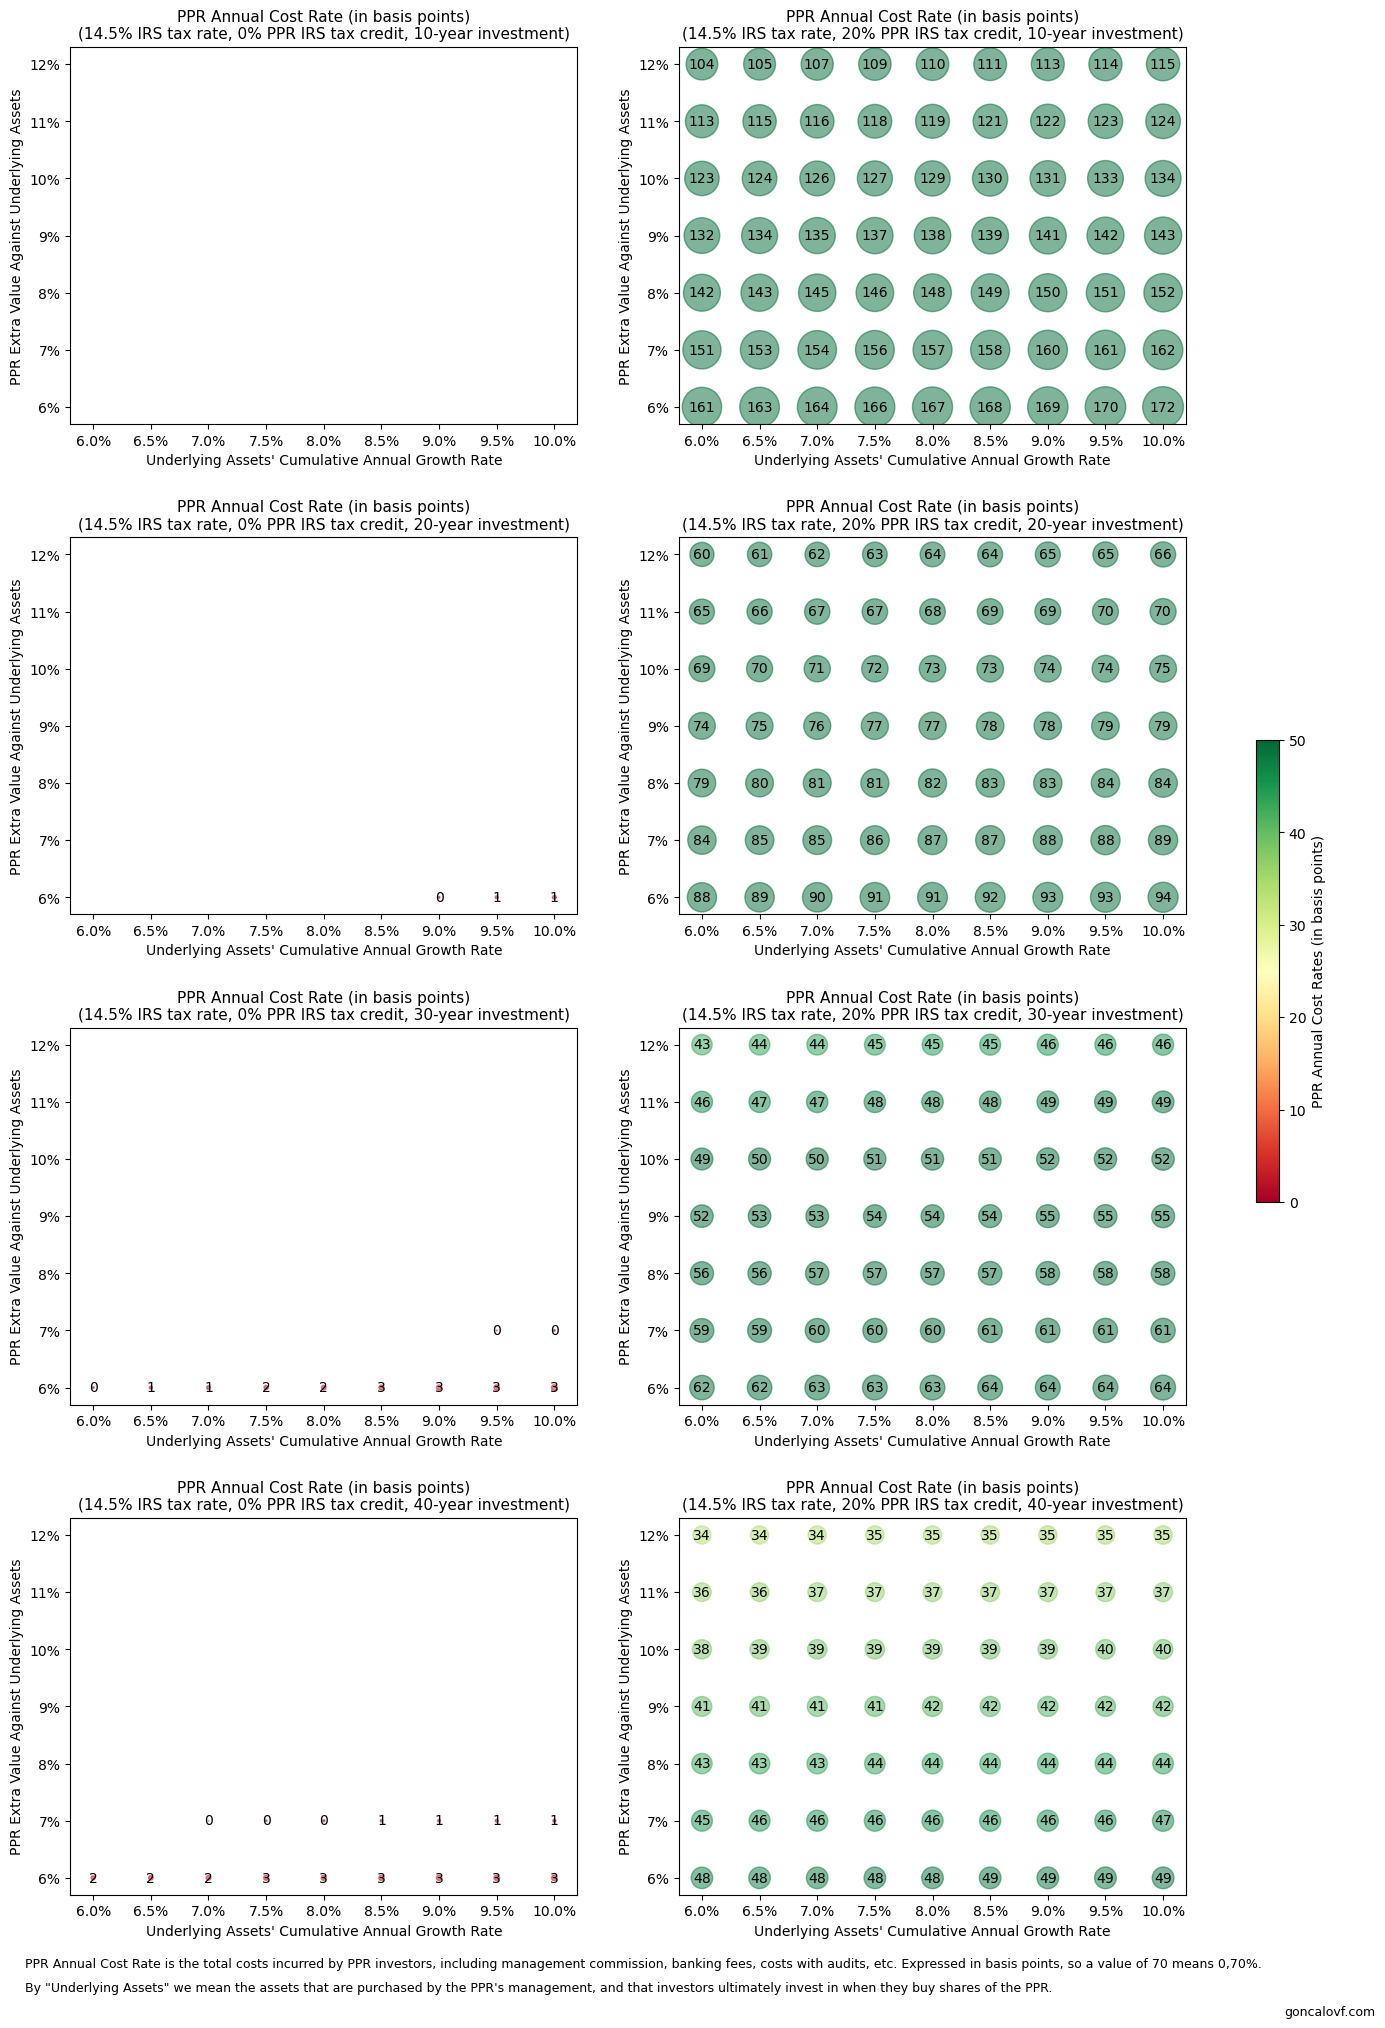

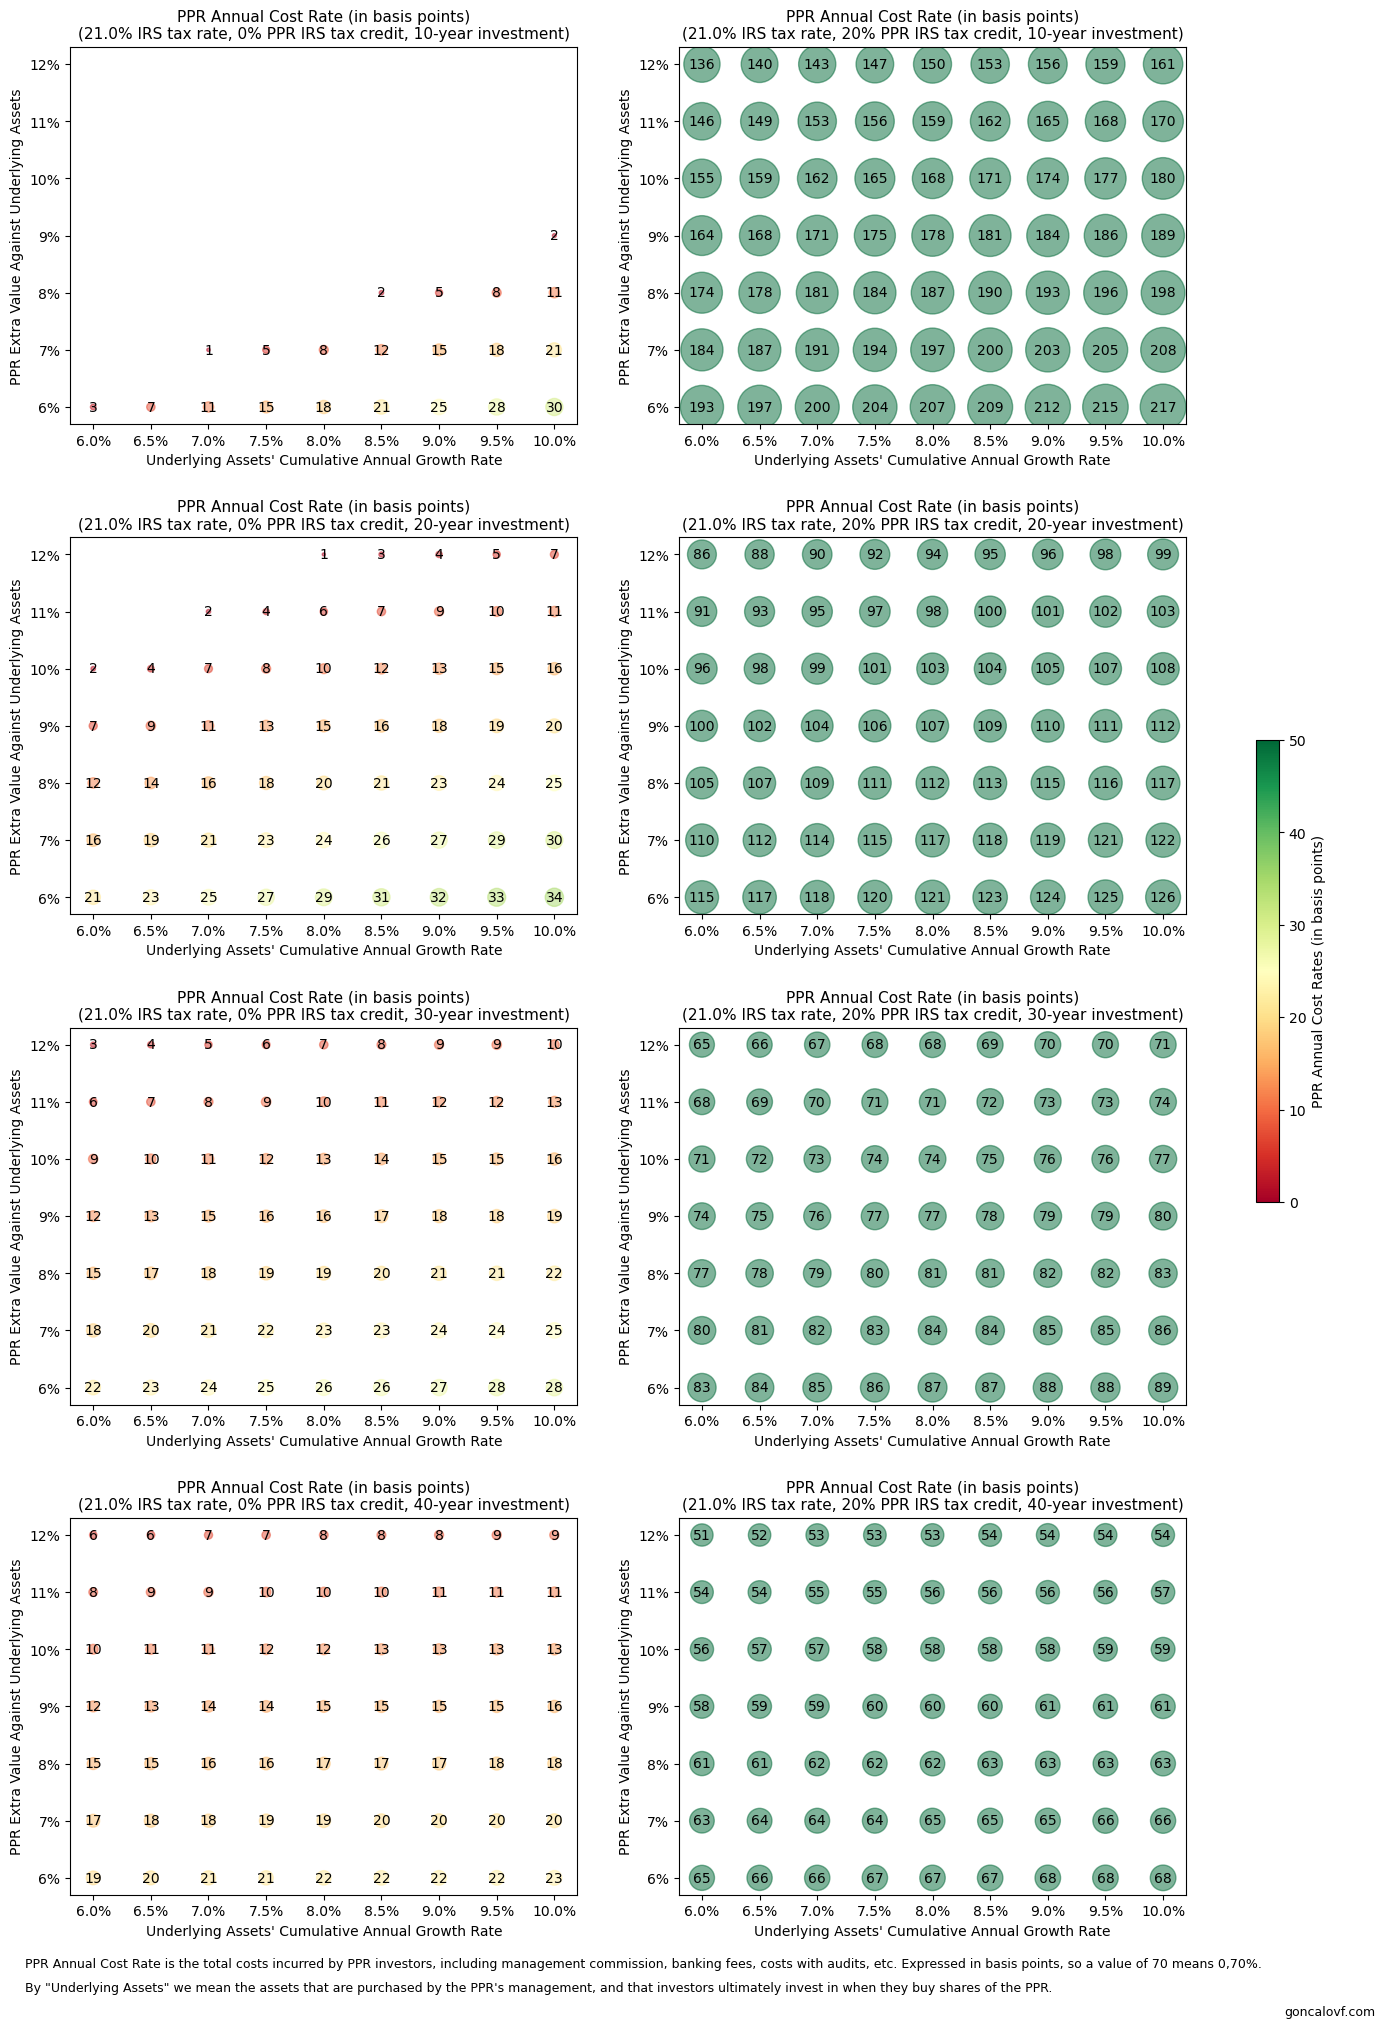

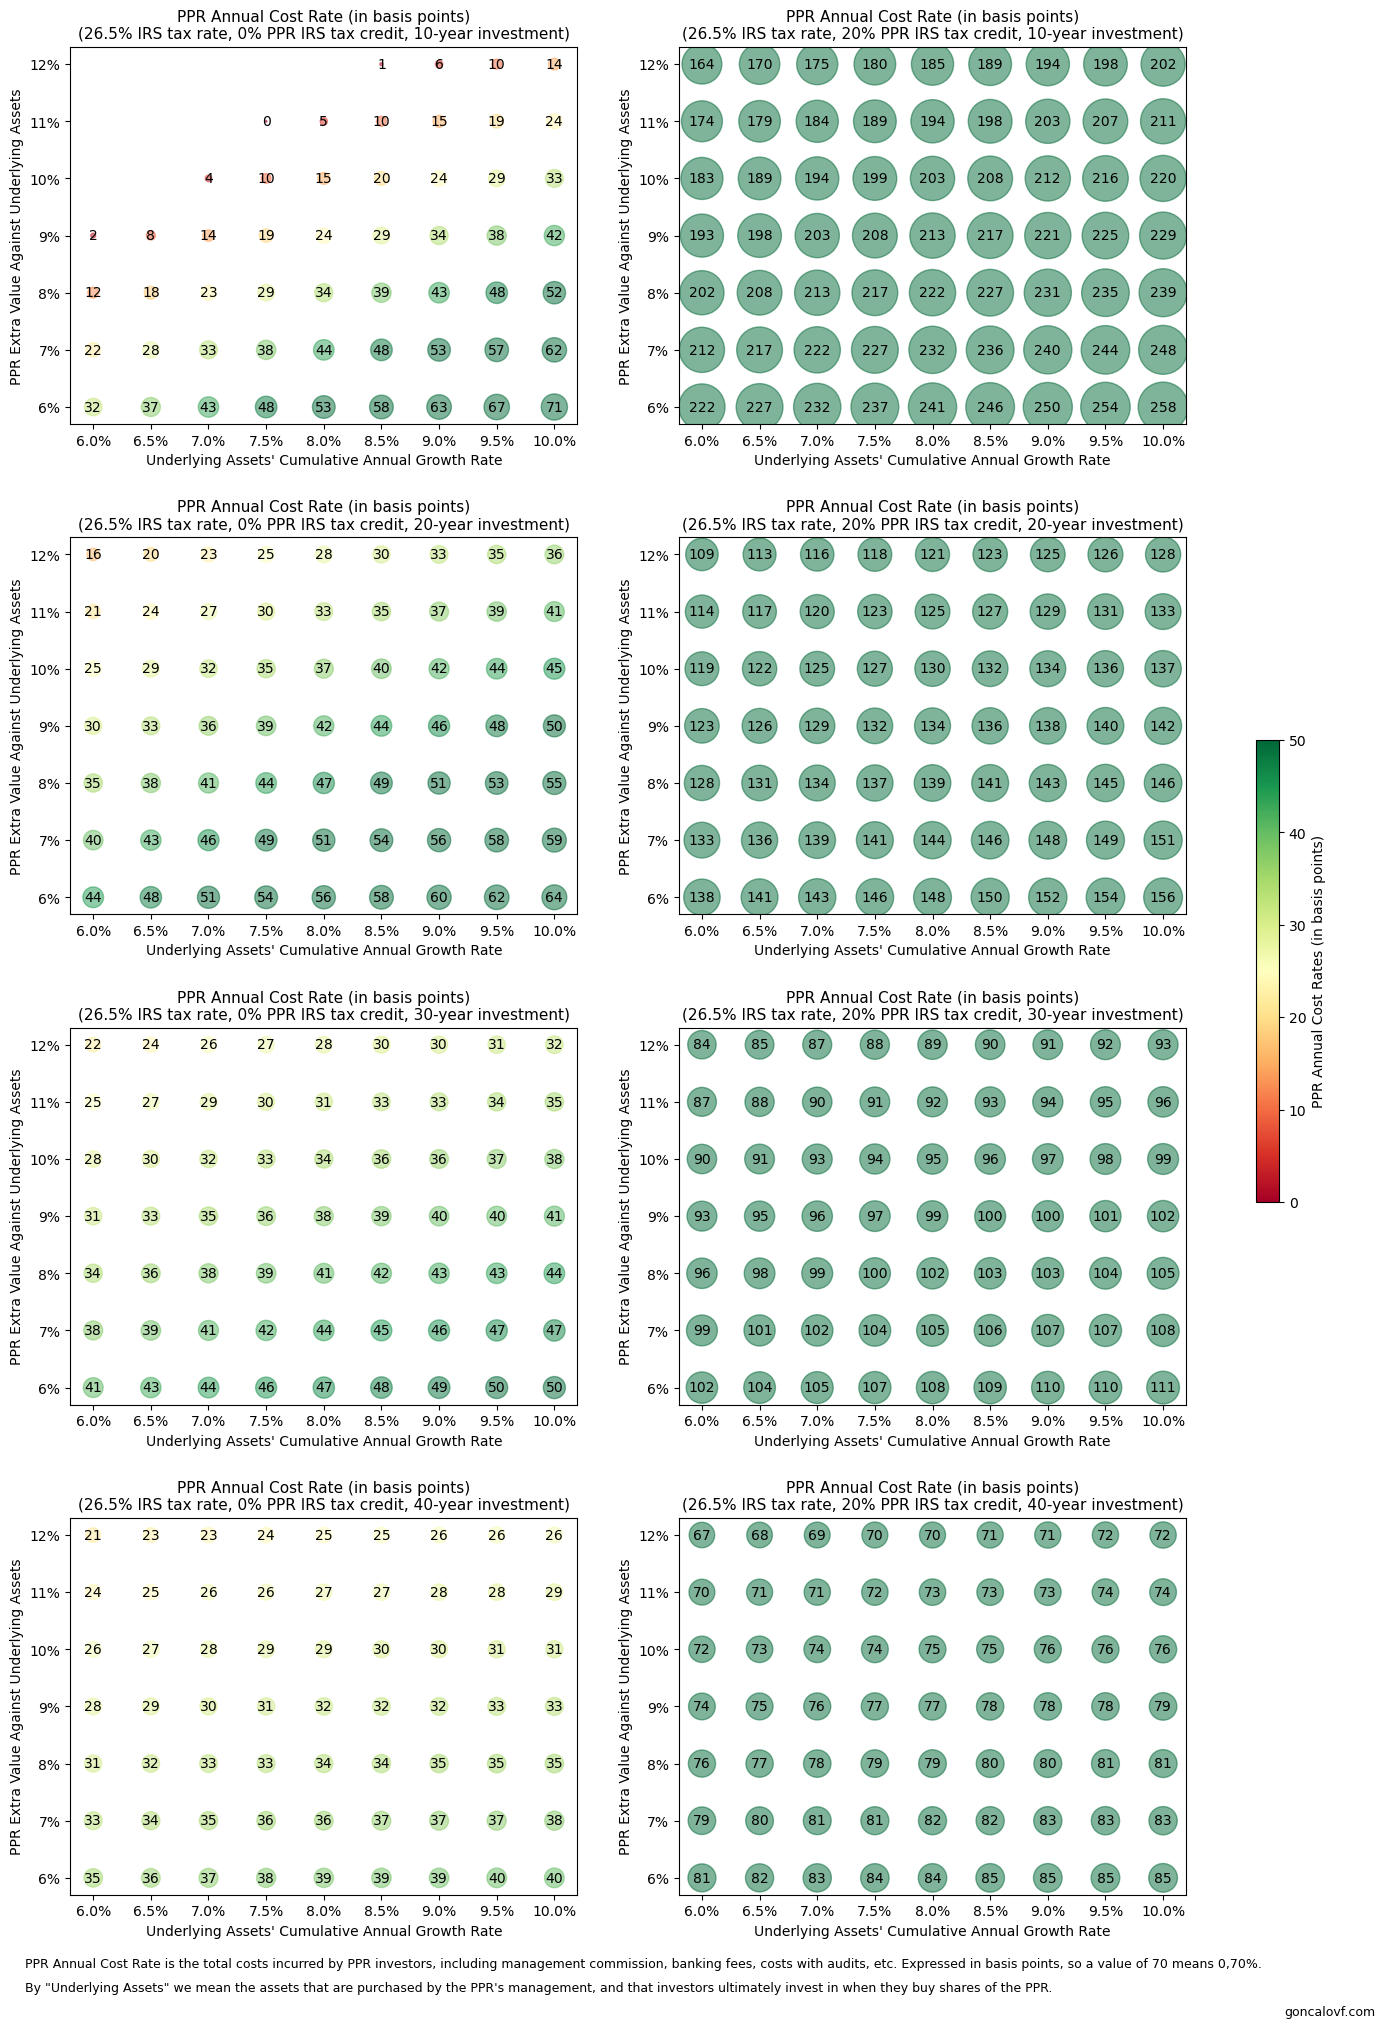

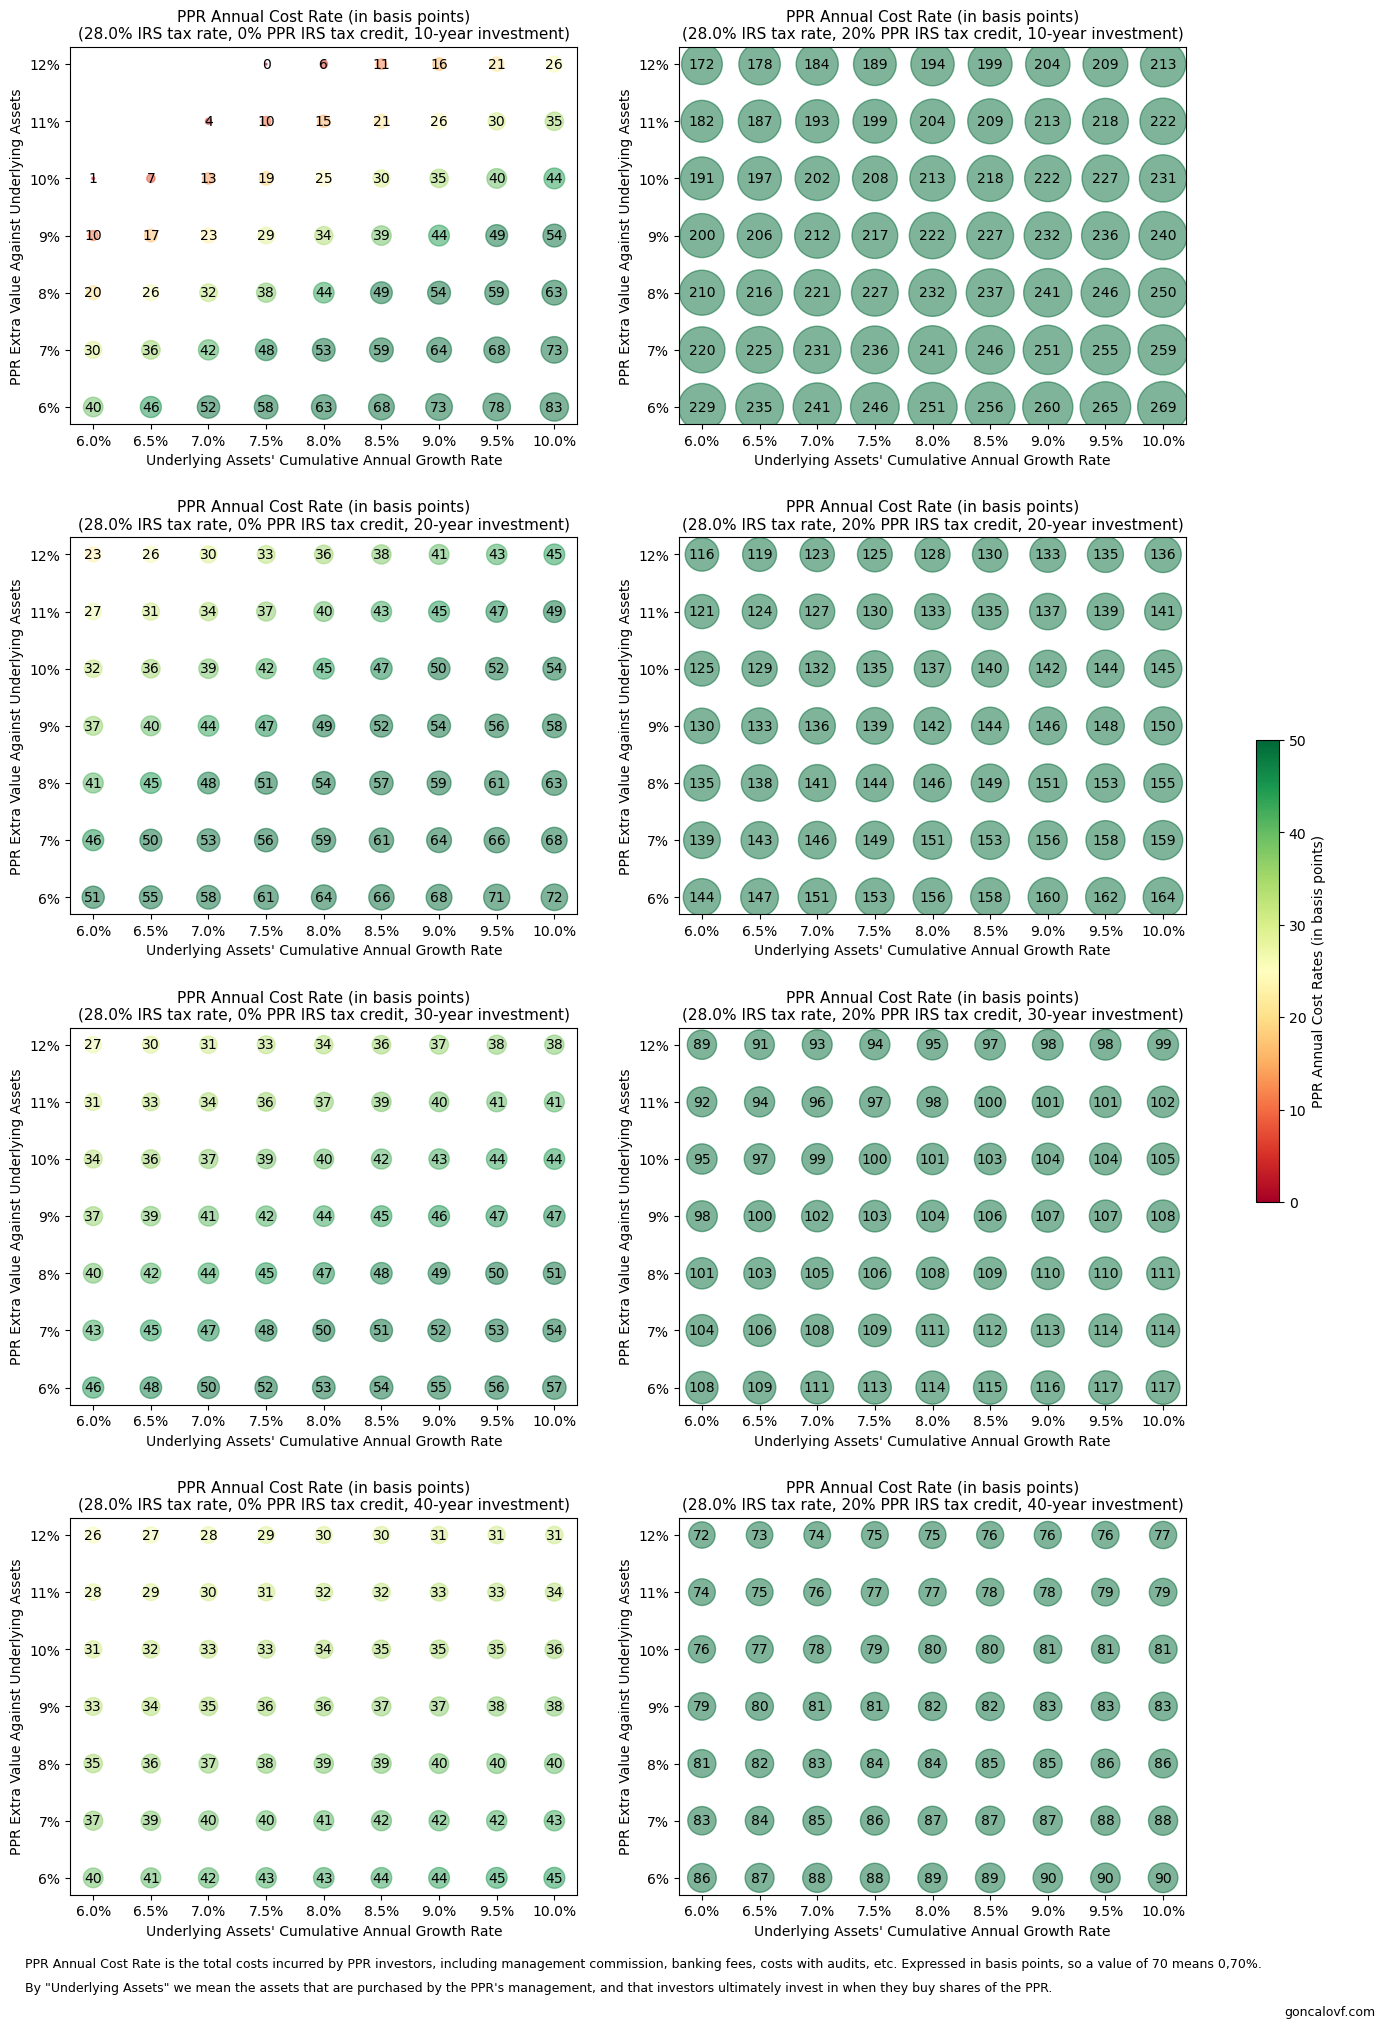

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pyppr

PERIODS = [10, 20, 30, 40]
PPR_REQUIRED_EXTRA_VALUE = [x / 1000 for x in range(60, 130, 10)]
PPR_TAX_CREDIT_PERCENTAGE = [0, 0.2]
UA_TAX_RANGE = [0.145, 0.21, 0.265, 0.28]
UA_CAGR = [x / 10000 for x in range(600, 1050, 50)] # In basis points.

df = pd.DataFrame(list(itertools.product(PERIODS, PPR_REQUIRED_EXTRA_VALUE, PPR_TAX_CREDIT_PERCENTAGE, UA_CAGR)), 
                            columns=['Periods', 'PPR Extra Value', 'PPR Tax Credit Percentage', 'UA CAGR'])

for ua_tax_rate in UA_TAX_RANGE:
    df['Management Commission'] = pyppr.matching_ppr_cost_rate(df['UA CAGR'], df['Periods'], ua_tax_rate, df['PPR Extra Value'], df['PPR Tax Credit Percentage'], True)

    fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(nrows=4, ncols=2, sharex="all", sharey=True, figsize=(18, 24))

    cmap = plt.get_cmap('RdYlGn')
    norm = plt.Normalize(vmin=0, vmax=0.005)

    for row in range(len(PERIODS)):
        for col in range(len(PPR_TAX_CREDIT_PERCENTAGE)):
            ax = locals()["ax{}{}".format(row + 1, col + 1)]

            df_filtered = df[
                (df['Periods'] == PERIODS[row]) & 
                (df['PPR Tax Credit Percentage'] == PPR_TAX_CREDIT_PERCENTAGE[col]) &
                (df['Management Commission'] == df['Management Commission']) &
                (df['Management Commission'] >= 0)
                ].reset_index()

            colors = cmap(norm(df_filtered['Management Commission']))

            ax.scatter(df_filtered['UA CAGR'], df_filtered['PPR Extra Value'], s=abs(df_filtered['Management Commission']) * 50000, alpha=0.5, c=colors)

            ax.set_title(f'PPR Annual Cost Rate (in basis points)\n({ua_tax_rate * 100:.1f}% IRS tax rate, {PPR_TAX_CREDIT_PERCENTAGE[col] * 100:.0f}% PPR IRS tax credit, {PERIODS[row]}-year investment)', fontsize=11)

            for i, label in enumerate(df_filtered['Management Commission']):
                ax.annotate(f'{label * 10000:.0f}', (df_filtered['UA CAGR'][i], df_filtered['PPR Extra Value'][i]), ha='center', va='center')

            ax.yaxis.set_major_formatter(lambda x, pos: f'{x * 100:.0f}%')
            ax.xaxis.set_major_formatter(lambda x, pos: f'{x * 100:.1f}%')
            ax.yaxis.set_tick_params(which='both', labelleft=True)
            ax.xaxis.set_tick_params(which='both', labelbottom=True)
            ax.set_ylabel('PPR Extra Value Against Underlying Assets')
            ax.set_xlabel('Underlying Assets\' Cumulative Annual Growth Rate')
            
    fig.subplots_adjust(hspace=0.3)

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=(ax11, ax12, ax21, ax22, ax31, ax32, ax41, ax42), location='right', shrink=0.25, format=plt.FuncFormatter(lambda x, pos: f'{x * 10000:.0f}'))
    cbar.set_label('PPR Annual Cost Rates (in basis points)')

    fig.text(0.1, 0.08, ('PPR Annual Cost Rate is the total costs incurred by PPR investors, including management commission, banking fees, costs with audits, etc.'
        ' Expressed in basis points, so a value of 70 means 0,70%.'), ha='left', fontsize=9)
    fig.text(0.1, 0.07, ('By "Underlying Assets" we mean the assets that are purchased by the PPR\'s management, and that investors'
        ' ultimately invest in when they buy shares of the PPR.'), ha='left', fontsize=9)
    
    fig.text(0.85, 0.06, 'goncalovf.com', ha='right', fontsize=9)

    plt.show()

> Just to be sure that you know how to interpret the graph, let's take the following example:
> - I plan to withdraw today's investment 30 years from now.
> - I've already invested in other PPRs this year, so this investment I'm considering will not generate a tax credit.
> - I forsee that, when I withdraw this investment, my income will be high enough to make me opt for the 28% tax rate when withdrawing non-PPR investments.
> - When estimating a cumulative annual growth rate for the underlying assets over a 30-year period, I go with 8%.
> 
> In this case, I need to look at the second-to-last graph on the left. If the PPR charges 0.40% in management commissions and other costs, I can expect a 10% higher net value at the end > of those 30 years when investing through it instead of directly in the Underlying Assets. If the PPR charges 0.50%, I can expect a 7% higher net value instead.

You may ask, why are there empty spaces in the graphs? The empty spaces occur when the matching annual cost rate for the PPR is negative, meaning that there is no logical value for it that would make the PPR more attractive than investing directly in the Underlying Assets.

What can we conclude from the figure above?

First, let's look at how each variable affects the annual cost PPRs can charge:
- The higher the tax-net values we want, the lower the annual costs need to be (obviously).
- The stronger the underlying assets' performance, the less punitive annual costs are to the overall performance, and so the higher they can be. PPRs should not include asset classes that typically yield lower returns, like bonds.
- The lower the tax rate charged on direct investments, the lower the annual costs need to be, because the PPR's tax benefits are also relatively less significant.
- When the investment in the PPR generates a tax credit and this credit is reinvested in the PPR, a same annual cost generates a much higher extra value.
- The relationship between the holding period and the annual cost is mixed, but in general, the longer the holding period, the lower the annual costs need to be.

## MSCI World historical performance 

To draw more conclusion, we'll need to have some expectation for the underlying assets' performance over these time frames, to know where in the graphs' x-axis we should look at. To have that expectation, let's look at the historical returns of the [MSCI World Index](https://www.msci.com/our-solutions/indexes/developed-markets).

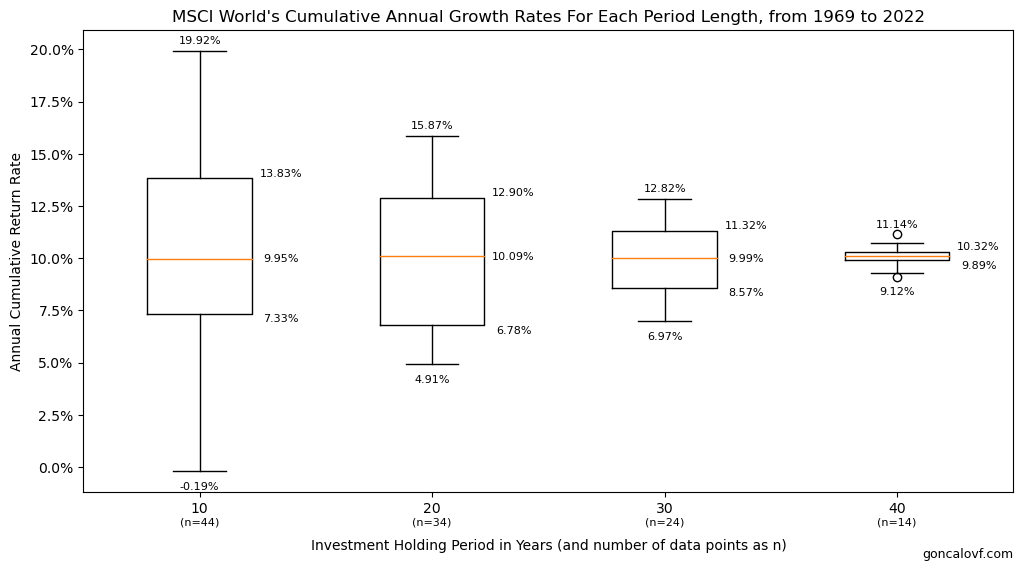

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PERIODS = [10, 20, 30, 40]

msci_world = pd.read_csv('./data/msci-world.csv', index_col='Date', parse_dates=True, dtype={'MSCI World Gross USD':float})

msci_world = msci_world.resample('A').last()

for period_length in PERIODS:
    msci_world[f'{period_length}-year Period Start'] = msci_world.index - pd.DateOffset(years=period_length)
    mask = msci_world[f'{period_length}-year Period Start'].isin(msci_world.index)
    msci_world.loc[mask, f'{period_length}-year Period Start Value'] = msci_world.loc[msci_world[f'{period_length}-year Period Start'][mask], 'MSCI World Gross USD'].values
    msci_world.loc[mask, f'{period_length}-year Period Cumulative Return Rate'] = ( msci_world.loc[mask, 'MSCI World Gross USD'] / msci_world.loc[mask, f'{period_length}-year Period Start Value'] ) ** (1/period_length) - 1

fig, ax = plt.subplots(figsize=(12, 6))

data = [msci_world[f'{period_length}-year Period Cumulative Return Rate'].dropna() for period_length in PERIODS]

ax.boxplot(data, labels=PERIODS)
ax.set_title('MSCI World\'s Cumulative Annual Growth Rates For Each Period Length, from 1969 to 2022')
ax.set_ylabel('Annual Cumulative Return Rate')
ax.set_xlabel('Investment Holding Period in Years (and number of data points as n)')
ax.yaxis.set_major_formatter(lambda x, pos: f'{x * 100:.1f}%')
ax.xaxis.set_label_coords(0.5, -0.1)

for i, box_vals in enumerate(data):
    legends = [
        { 'x': i + 1,   'y': max(box_vals), 'yoffset': 0.0025, 'va': 'bottom' },
        { 'x': i + 1.35, 'y': np.quantile(box_vals, 0.75), 'yoffset': 0, 'va': 'bottom' },
        { 'x': i + 1.35, 'y': np.quantile(box_vals, 0.50), 'yoffset': 0, 'va': 'center' },
        { 'x': i + 1.35, 'y': np.quantile(box_vals, 0.25), 'yoffset': 0, 'va': 'top' },
        { 'x': i + 1,   'y': min(box_vals), 'yoffset': -0.005, 'va': 'top' },
    ]

    for j, legend in enumerate(legends):
        if ( j == 2 and legends[j - 1]['y'] - legends[j + 1]['y'] < 0.01 ):
            continue

        ax.text(legend['x'], legend['y'] + legend['yoffset'], f"{legend['y']:0.2%}", ha='center', va=legend['va'], fontsize=8)

    ax.text(i + 1, -0.028, f'(n={len(box_vals)})', ha='center', fontsize=8)

fig.text(0.9, 0.00, 'goncalovf.com', ha='right', fontsize=9)

plt.show()

Note that the MSCI World Index is, as the name implies, an index and not an investable asset. However, there are assets (namely ETFs) that track it, with virtually no tracking error, so we can consider it as a good benchmark for the "underlying assets". We chose the index because it has longer historical data than those tracking financial products.

This graph tells us a lot of information regarding historical returns.

First, we can see that there's a much wider variance of returns in shorter holding periods than in longer. This effect may be overstated here because our data only starts at 1969, and therefore there aren't many 30 and 40 year periods to include in the analysis. However, this finding goes along the general understanding of how equity markets work.

Second, it's curious to see that, despite the very significant difference in variance, the median value hits almost exactly at 10% in all the considered holding periods. That means that, in all the 10-, 20-, 30- and 40-year holding periods observed since 1969, the cumulative annual growth rates (CAGR) on half the instances was below 10%, and above 10% in the other half. 

If we consider the middle half of observed CAGRs, they're roughly always between 7% and 14%. In fact, on 30-year holding periods or longer, all observed CAGRs fit inside that range.

By matching the two figures above, I chose 0.4% as the balanced annual cost rate to give PPR-fund managers the revenue needed to cover costs and make a profit, while still making the PPR an attractive choice for investors.

## Back-testing with MSCI World

Now, let's do some back-testing. If there was a PPR with 0.4% annual cost rate tracking the MSCI World Index, how would it compare to the alternative of investing directly in the index (through a product that tracks it)? Note that, in this back-test, we consider that the investment in the PPR doesn't originate a tax credit, since we saw above that, with the tax credit, the PPR is still attractive with annual cost rate much higher than 0.4%.

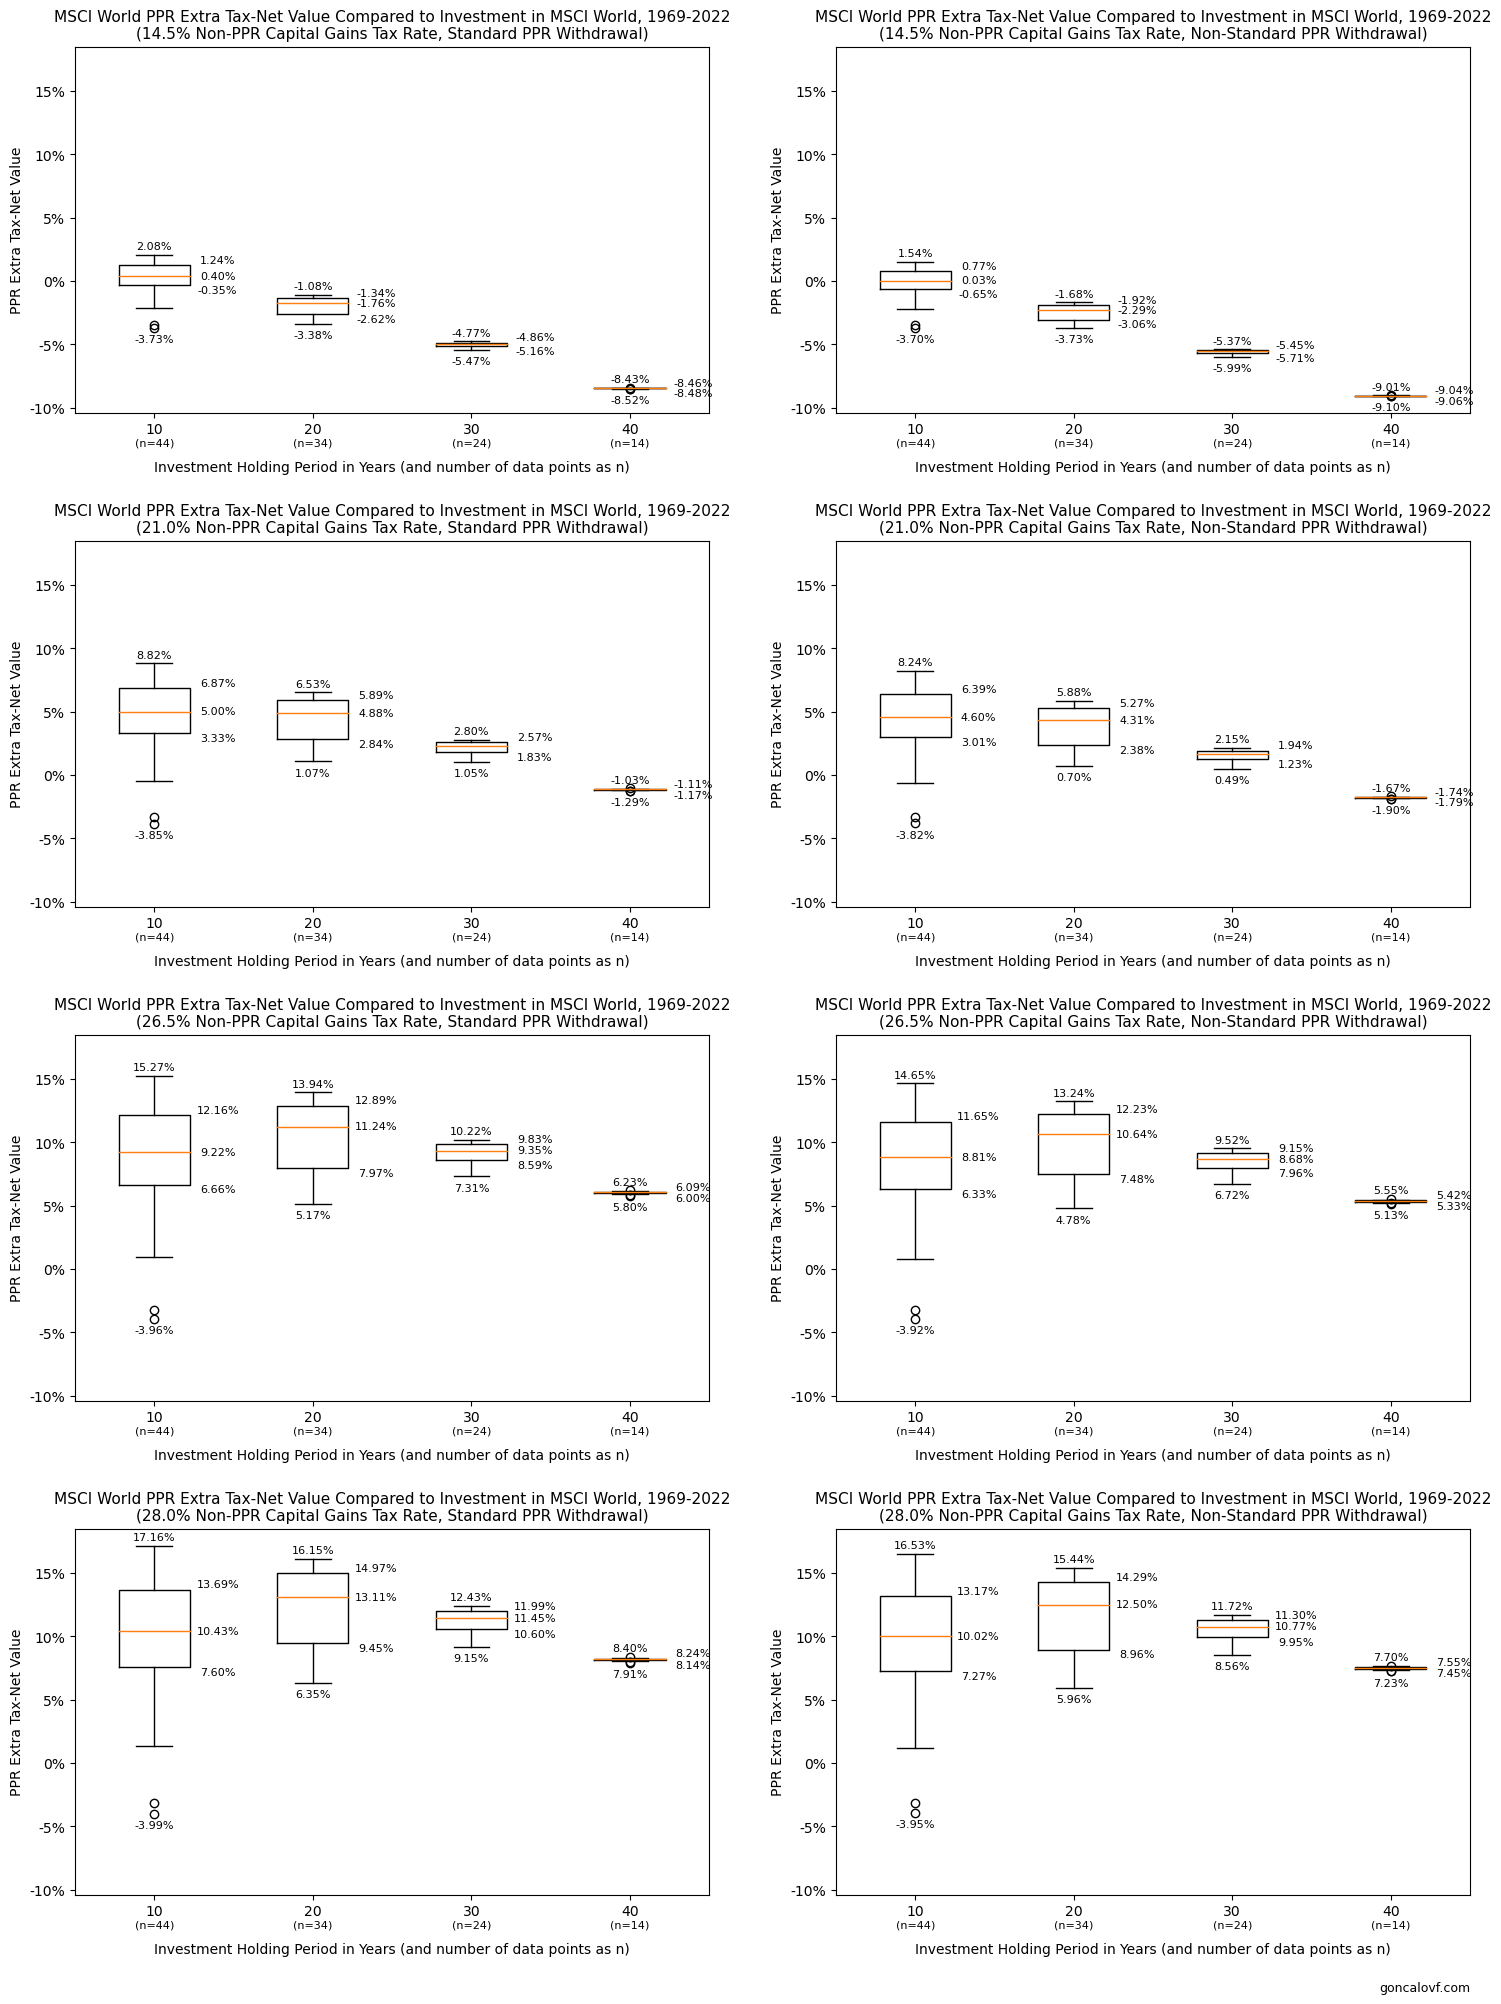

In [24]:
PERIODS = [10, 20, 30, 40]
UA_TAX_RANGE = [0.145, 0.21, 0.265, 0.28]
PPR_CR = 0.004
PPR_TC = 0

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(nrows=4, ncols=2, sharey=True, figsize=(18, 24))

for row, ua_tax_rate in enumerate(UA_TAX_RANGE):
    for col, ppr_standard_widthdrawal in enumerate([True, False]):
        ax = locals()["ax{}{}".format(row + 1, col + 1)]

        data = []

        for period_length in PERIODS:
            column_name = f'{period_length}-year {"Standard" if ppr_standard_widthdrawal else "Non-Standard"} Withdrawal PPR Extra Value'
            msci_world[column_name] = msci_world[f'{period_length}-year Period Cumulative Return Rate'].apply(lambda x: pyppr.matching_ppr_extra_value(x, period_length, ua_tax_rate, PPR_CR, PPR_TC, ppr_standard_widthdrawal))
            data.append(msci_world[column_name].dropna())

        ax.boxplot(data, labels=PERIODS)
        ax.set_title(f'MSCI World PPR Extra Tax-Net Value Compared to Investment in MSCI World, 1969-2022\n({ua_tax_rate:.1%} Non-PPR Capital Gains Tax Rate, {"Standard" if ppr_standard_widthdrawal else "Non-Standard"} PPR Withdrawal)', fontsize=11)
        ax.set_ylabel('PPR Extra Tax-Net Value')
        ax.set_xlabel('Investment Holding Period in Years (and number of data points as n)')

        ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.0%}')
        ax.yaxis.set_tick_params(which='both', labelleft=True)
        ax.xaxis.set_tick_params(which='both', labelbottom=True)

        ax.xaxis.set_label_coords(0.5, -0.13)

        for i, box_vals in enumerate(data):
            legends = [
                { 'x': i + 1,   'y': max(box_vals), 'yoffset': 0.0025, 'va': 'bottom' },
                { 'x': i + 1.4, 'y': np.quantile(box_vals, 0.75), 'yoffset': 0, 'va': 'bottom' },
                { 'x': i + 1.4, 'y': np.quantile(box_vals, 0.50), 'yoffset': 0, 'va': 'center' },
                { 'x': i + 1.4, 'y': np.quantile(box_vals, 0.25), 'yoffset': 0, 'va': 'top' },
                { 'x': i + 1,   'y': min(box_vals), 'yoffset': -0.005, 'va': 'top' },
            ]

            for j, legend in enumerate(legends):
                if ( j == 2 and legends[j - 1]['y'] - legends[j + 1]['y'] < 0.01 ):
                    continue

                ax.text(legend['x'], legend['y'] + legend['yoffset'], f"{legend['y']:0.2%}", ha='center', va=legend['va'], fontsize=8)

            ax.text(i + 1, -0.13, f'(n={len(box_vals)})', ha='center', fontsize=8)

    fig.subplots_adjust(hspace=0.35)

fig.text(0.9, 0.075, 'goncalovf.com', ha='right', fontsize=9)

plt.show()

## Conclusions

From this back-test, we can conclude that, considering a PPR with an annual cost rate of 0.4%:
- The PPR is only a rational choice if the investor faces a 26.5% or 28% tax rate on withrawals of self-invested assets.
- That annual cost rate (of 0.4%) is the maximum a PPR investor can be charged with and still get a premium that compensates for PPRs' hassle and limitations. 